In [1]:
#if user input
import yfinance as yf

def fetch_historical_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example usage
ticker = "AAPL"  # User input
start_date = "2020-01-01"  # User input
end_date = "2023-01-01"  # User input
data = fetch_historical_data(ticker, start_date, end_date)
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800
2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200
2020-01-07,72.241539,72.849216,72.021223,72.592586,108872000
2020-01-08,73.403656,73.706287,71.943766,71.943766,132079200


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

prices = data['Close'].values.reshape(-1, 1)
print(pd.DataFrame(prices).head())
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create sequences for LSTM
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_prices, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)



           0
0  72.716072
1  72.009125
2  72.582909
3  72.241539
4  73.403656


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
model.fit(X, y, epochs=20, batch_size=32, verbose=1)
loss, mae, rmse = model.evaluate(X, y, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
# Save the model
model.save('stock_lstm_model.h5')

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.1869 - mean_absolute_error: 0.3456 - root_mean_squared_error: 0.4137
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0076 - mean_absolute_error: 0.0721 - root_mean_squared_error: 0.0872
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0043 - mean_absolute_error: 0.0538 - root_mean_squared_error: 0.0652
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0029 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0536
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0023 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0478
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0020 - mean_absolute_error: 0.0354 - root_mean_squared_error: 0.0449
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0022 - mean_absolute_error: 0.0370 - root_mean_squared_error: 0.0465
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0020 - mean_absolute_error: 0

Test Loss: 0.0014502565609291196
Test MAE: 0.029627498239278793
Test RMSE: 0.03808223456144333


In [4]:
def fetch_real_time_data(ticker):
    tick=yf.Ticker(ticker)
    real_time_data = tick.info

    try:

        data = yf.download(ticker, period="1d", interval="1m")
        latest_price = real_time_data["regularMarketPrice"]
        return latest_price
    except Exception as e:
        print(f"Error fetching real-time data: {e}")
        return None

# Get user input for the stock ticker
ticker = input("Enter the stock ticker symbol (e.g., AAPL): ")

# Fetch and print the latest price
latest_price = fetch_real_time_data(ticker)

if latest_price is not None:
    print("Latest Price:", latest_price)
else:
    print("Could not fetch real-time data.")

Enter the stock ticker symbol (e.g., AAPL):  AAPL


[*********************100%***********************]  1 of 1 completed

Latest Price: 214.1


In [5]:
from tensorflow.keras.models import load_model

# Load the trained LSTM model
model = load_model('stock_lstm_model.h5')

# Prepare input for prediction
last_60_prices = scaled_prices[-time_step:]

last_60_prices = last_60_prices.reshape(1, time_step, 1)

# Predict next price
predicted_price_scaled = model.predict(last_60_prices)

predicted_price = scaler.inverse_transform(predicted_price_scaled)

print("Predicted Price:", predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Predicted Price: 128.79425


Enter the stock ticker symbol (e.g., AAPL):  AAPL


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


Enter the stock ticker symbol (e.g., AAPL):  AAPL


[*********************100%***********************]  1 of 1 completed


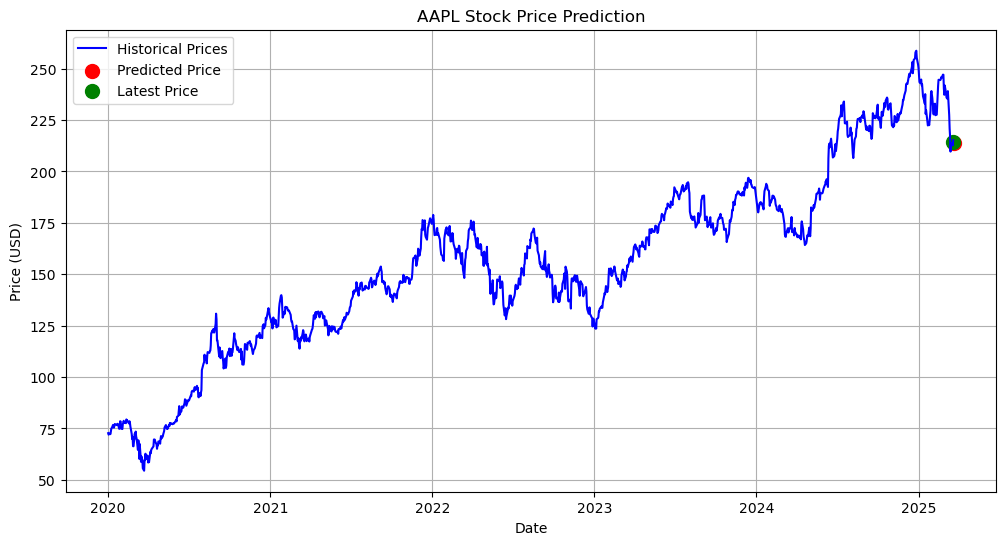

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Function to fetch real-time data
def fetch_real_time_data(ticker):
    tick = yf.Ticker(ticker)
    real_time_data = tick.info

    try:
        data = yf.download(ticker, period="1d", interval="1m")
        latest_price = real_time_data["regularMarketPrice"]
        return latest_price
    except Exception as e:
        print(f"Error fetching real-time data: {e}")
        return None

# Load the trained LSTM model
model = load_model('stock_lstm_model.h5')
ticker = input("Enter the stock ticker symbol (e.g., AAPL): ")

# Example: Historical data (replace with your actual data)
historical_data = yf.download(ticker, start="2020-01-01", end="2025-03-20")
prices = historical_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Prepare input for prediction
time_step = 60
last_60_prices = scaled_prices[-time_step:]
last_60_prices = last_60_prices.reshape(1, time_step, 1)

# Predict next price
predicted_price_scaled = model.predict(last_60_prices)
predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]

# Fetch real-time data
ticker = input("Enter the stock ticker symbol (e.g., AAPL): ")
latest_price = fetch_real_time_data(ticker)

# Plot the data
plt.figure(figsize=(12, 6))

# Plot historical prices
plt.plot(historical_data.index, prices, label='Historical Prices', color='blue')

# Plot predicted price
predicted_index = historical_data.index[-1] + pd.Timedelta(days=1)  # Next day
plt.scatter(predicted_index, predicted_price, color='red', label='Predicted Price', s=100)

# Plot latest price
if latest_price is not None:
    latest_index = historical_data.index[-1]  # Current time
    plt.scatter(latest_index, latest_price, color='green', label='Latest Price', s=100)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.grid(True)


# Show the plot
plt.show()

In [7]:
from flask import Flask, request, jsonify
app = Flask(__name__)
@app.route('/predict', methods=['GET'])
def predict():
    ticker = request.args.get('ticker')
    if not ticker:
        return jsonify({"error": "Ticker symbol is required"}), 400

    # Fetch real-time data
    latest_price = fetch_real_time_data(ticker)

    # Predict next price
    predicted_price = predict_next_price(ticker)

    # Return results
    return jsonify({
        "ticker": ticker,
        "latest_price": latest_price,
        "predicted_price": predicted_price
    })

# Run the Flask app
if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\acer\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
